In [1]:
import math

Подключим Keras и все необходимые нам модули

In [2]:
import keras
from keras import applications
from keras.applications import imagenet_utils
from keras import backend as K
import numpy as np
import tensorflow as tf

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
from scipy.misc import imresize

ImportError: cannot import name 'imresize' from 'scipy.misc' (/usr/local/lib/python3.7/site-packages/scipy/misc/__init__.py)

In [4]:
from imageio import imread, imwrite

ModuleNotFoundError: No module named 'imageio'

In [5]:
sess = K.get_session()
sess.as_default()

In [6]:
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10) # set default size of plots

В модуле applications вы сможете найти большое количество предтренированных моделей. Загрузим уже знакомый нам VGG16, обученный на Imagenet

In [7]:
# build the VGG16 network
K.clear_session()
model = applications.VGG16(include_top=True,
                           weights='imagenet')

В Keras существуют удобные средства для визуализации моделей. 

In [8]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [10]:
def build_train_function(layer_name = 'predictions', indexes = 0):
    # Получаем тензор, отвечающий за вход модели
    input_img = model.input
    
    if layer_name not in layer_dict:
        raise Error('There is no such layer')
    
    # Выберем нужный слой
    layer = layer_dict[layer_name].output
    
    # А из него интересующие нас узлы
    objective = layer[indexes]

    # Вызываем метод бэкенда, рассчитывающий градиент
    grads = K.gradients(objective, input_img)[0]

    # Оборачиваем всё это в специальную абстракцию,
    # которая скрывает вызов сессии TF
    return K.function([input_img], [grads, objective])

In [11]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [12]:
def compute_image(train_function, max_iter = 50, lr = 1):
    input_img_data = np.random.normal(size=(1, 224, 224, 3))
    for i in range(max_iter):
        grads_value, objective_value = train_function([input_img_data])
        grads_value /= grads_value.std()+1e-8    
        input_img_data += grads_value * lr
        print(f'objective: {np.mean(objective_value):.2}', end='\r')
    
    img = input_img_data[0]
    img = deprocess_image(img)
    return img.astype(np.uint8)

In [13]:
traint_func = build_train_function(layer_name='block3_conv1', indexes=(slice(None), slice(None), slice(None), 7))

In [15]:
img_ = compute_image(traint_func, max_iter=200, lr=0.5)


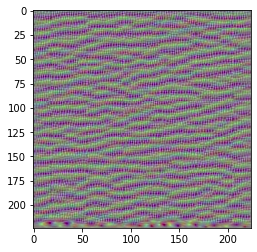

In [17]:
plt.imshow(img_.astype(np.uint8))

In [18]:
def stitch_images(images, margin=5, cols=5):
    """Utility function to stitch images together with a `margin`.

    Args:
        images: The array of 2D images to stitch.
        margin: The black border margin size between images (Default value = 5)
        cols: Max number of image cols. New row is created when number of images exceed the column size.
            (Default value = 5)

    Returns:
        A single numpy image array comprising of input images.
    """
    if len(images) == 0:
        return None

    h, w, c = images[0].shape
    n_rows = int(math.ceil(len(images) / cols))
    n_cols = min(len(images), cols)

    out_w = n_cols * w + (n_cols - 1) * margin
    out_h = n_rows * h + (n_rows - 1) * margin
    stitched_images = np.zeros((out_h, out_w, c), dtype=images[0].dtype)

    for row in range(n_rows):
        for col in range(n_cols):
            img_idx = row * cols + col
            if img_idx >= len(images):
                break

            stitched_images[(h + margin) * row: (h + margin) * row + h,
                            (w + margin) * col: (w + margin) * col + w, :] = images[img_idx]

    return stitched_images

In [19]:
a = layer_dict['block2_conv2'].output

In [20]:
K.int_shape(a)

(None, 112, 112, 128)

In [21]:
def visualize_random_chanels(layers = ['block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3'], max_iter = 200):
    for layer_name in layers:
        
        activation_map = layer_dict[layer_name].output
        shape = K.int_shape(activation_map)
        filters = np.random.permutation(shape[-1])[:10]

        vis_images = []
        for idx in filters:
            train_function = build_train_function(layer_name, 
                                                  indexes=(slice(None), slice(None),slice(None), idx))

            image = compute_image(train_function, max_iter)
  
            vis_images.append(image)

        print(f'visualizations of layer: {layer_name}')
        stitched = stitch_images(vis_images, cols=5)    
        plt.figure()
        plt.axis('off')
        plt.imshow(stitched)
        plt.show()

In [ ]:
visualize_random_chanels()

In [ ]:
train_function = build_train_function('block4_conv2', indexes=(slice(None), slice(None),slice(None), 8))
image = compute_image(train_function)

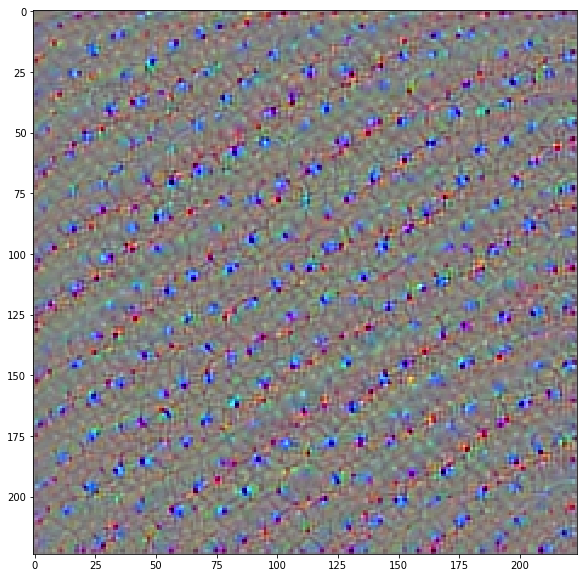

In [24]:
plt.imshow(image)

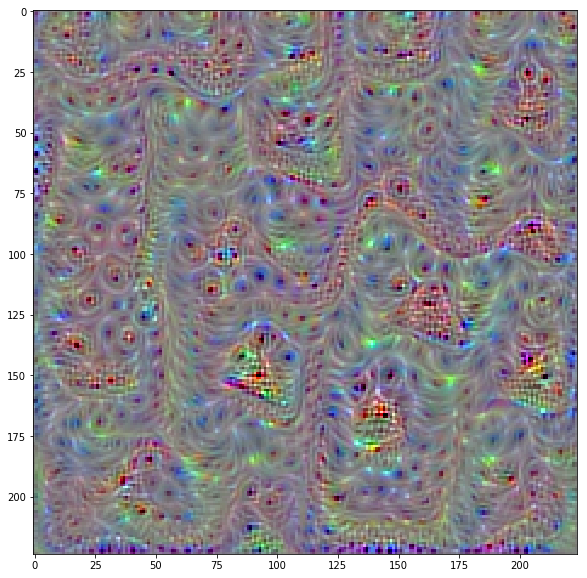

In [26]:
train_function = build_train_function('block5_conv1', indexes=(slice(None), slice(None),slice(None), 66))
image = compute_image(train_function)
plt.imshow(image)

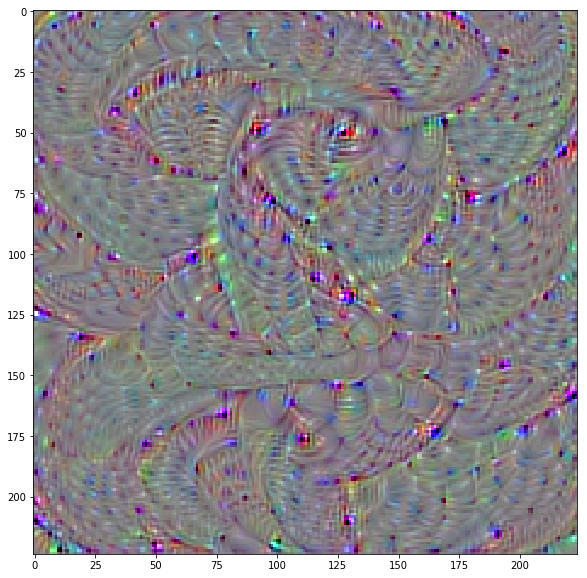

In [27]:
train_function = build_train_function('block5_conv3', indexes=(slice(None), slice(None),slice(None), 66))
image = compute_image(train_function, 500)
plt.imshow(image)

In [28]:
classes

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

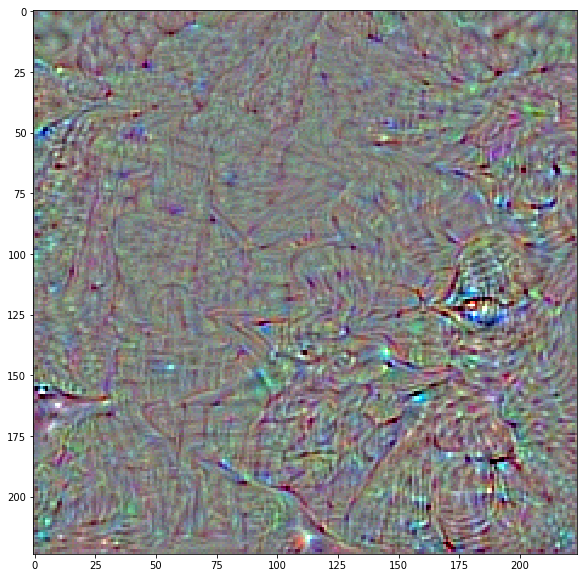

In [28]:
train_function = build_train_function('predictions', indexes=(slice(None), 20))
image = compute_image(train_function, 300, lr=0.8)
plt.imshow(image)

In [29]:
def build_train_function_reg(layer_name = 'predictions', indexes = 0, reg_coef = 1, p=6):
    # Получаем тензор, отвечающий за вход модели
    input_img = model.input
    
    if layer_name not in layer_dict:
        raise Error('There is no such layer')
        
    # Выберем нужный слой
    layer = layer_dict[layer_name].output
    
    
    value = K.pow(K.sum(K.pow(K.abs(input_img), p)), 1. / p)
    value /=  np.prod(K.int_shape(input_img)[1:])
    objective = K.mean(layer[indexes]) - reg_coef * value
    
    # Вызываем метод бэкенда, рассчитывающий градиент
    grads = K.gradients(objective, input_img)[0]

    # Оборачиваем всё это в специальную абстракцию,
    # которая скрывает вызов сессии TF
    return K.function([input_img], [grads, objective])

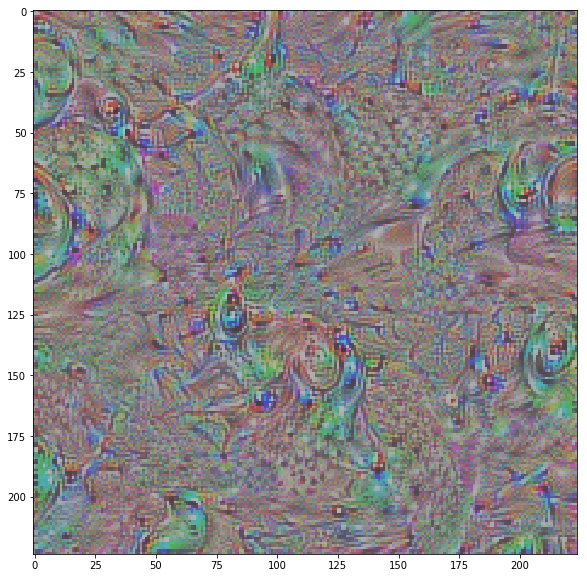

In [32]:
train_function = build_train_function_reg('predictions', indexes=(slice(None), 30), reg_coef=2)
image = compute_image(train_function, 100, lr=0.3)
plt.imshow(image)

In [33]:
def create_blur_function():
    input_img = K.placeholder(shape=(1, 224, 224, 3))
    
    k = np.float32([1,4,6,4,1])
    k = np.outer(k, k)
    gausiian_blur_kernel = k[:,:,None,None]/k.sum()*np.eye(3, dtype=np.float32)
    
    blurred = K.conv2d(input_img, gausiian_blur_kernel, (1,1), 'same')
    
    return K.function([input_img], [blurred])

In [34]:
blur_func = create_blur_function()

In [35]:
def compute_image_with_blur(train_function, max_iter = 50, lr = 1, blur_freq = 5):
    input_img_data = np.random.normal(size=(1, 224, 224, 3)).astype(np.float32)
    
    for i in range(max_iter):
        
        if blur_freq is not None and i % blur_freq == 0:
            input_img_data = blur_func([input_img_data])[0]
        
        grads_value, objective_value = train_function([input_img_data])
        grads_value /= grads_value.std()+1e-8    
        input_img_data += grads_value * lr
        print(f'objective: {np.mean(objective_value):.2}', end='\r')
    
    img = input_img_data[0]
    img = deprocess_image(img)
    return img

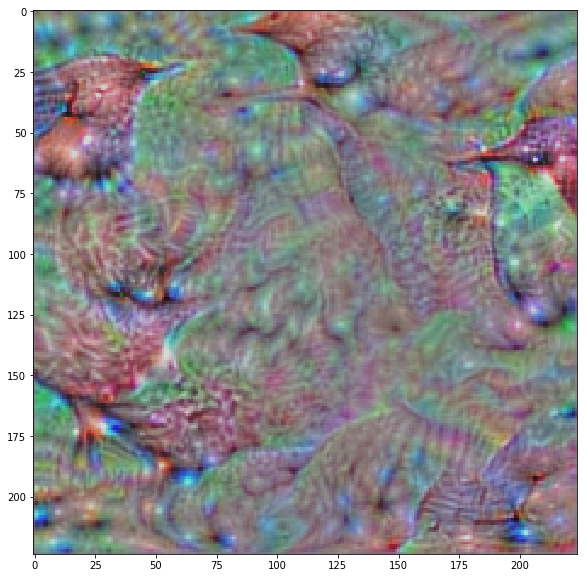

In [37]:
train_function = build_train_function_reg('predictions', indexes=(slice(None), 20), reg_coef=2)
image = compute_image_with_blur(train_function, 100, lr=0.5, blur_freq=5)
plt.imshow(image)

In [38]:
def apply_laplacian_pyramid(image, n_split):
    k = np.float32([1,4,6,4,1])
    k = np.outer(k, k)
    gausiian_blur_kernel = k[:,:,None,None]/k.sum()*np.eye(3, dtype=np.float32)
    
    def lap_split(img):
        '''Split the image into lo and hi frequency components'''
        print(K.int_shape(img))
        low_frequency_small = K.conv2d(img, gausiian_blur_kernel, padding='same', strides=(2,2))
        low_frequency_big = K.conv2d_transpose(low_frequency_small, gausiian_blur_kernel*4, output_shape=tf.shape(img), padding='same', strides=(2,2))
        hi = img - low_frequency_big
        return low_frequency_small, hi
    
    def lap_split_n(img, n):
        '''Build Laplacian pyramid with n splits'''
        levels = []
        for i in range(n):
            img, hi = lap_split(img)
            levels.append(hi)
        levels.append(img)
        return levels[::-1]
    
    def lap_merge(levels):
        '''Merge Laplacian pyramid'''
        img = levels[0]
        for hi in levels[1:]:
            img = K.conv2d_transpose(img, gausiian_blur_kernel*4, tf.shape(hi), (2,2), padding='same') + hi
        return img
    
    def normalize_std(img, eps=1e-10):
        '''Normalize image by making its standard deviation = 1.0'''
        std = K.sqrt(K.mean(K.square(img)))
        return img/K.maximum(std, eps)
    
    def lap_normalize(img, scale_n=4):
        
        '''Perform the Laplacian pyramid normalization.'''
        tlevels = lap_split_n(img, scale_n)
        tlevels = list(map(normalize_std, tlevels))
        out = lap_merge(tlevels)
        return out[0,:,:,:]
    
    return lap_normalize(image, n_split)

In [39]:
def build_train_function_reg_laplass(layer_name = 'predictions', indexes = 0, reg_coef = 1, p=6, n_split=4):
    # Получаем тензор, отвечающий за вход модели
    input_img = model.input
    
    if layer_name not in layer_dict:
        raise Error('There is no such layer')
        
    # Выберем нужный слой
    layer = layer_dict[layer_name].output
    
    
    value = K.pow(K.sum(K.pow(K.abs(input_img), p)), 1. / p)
    value /=  np.prod(K.int_shape(input_img)[1:])
    objective = K.mean(layer[indexes]) - reg_coef * value
    
    # Вызываем метод бэкенда, рассчитывающий градиент
    grads = K.gradients(objective, input_img)[0]
    grads = apply_laplacian_pyramid(grads, n_split)
    # Оборачиваем всё это в специальную абстракцию,
    # которая скрывает вызов сессии TF
    return K.function([input_img], [grads, objective])

(None, 224, 224, 3)
(None, 112, 112, 3)
(None, 56, 56, 3)
(None, 28, 28, 3)


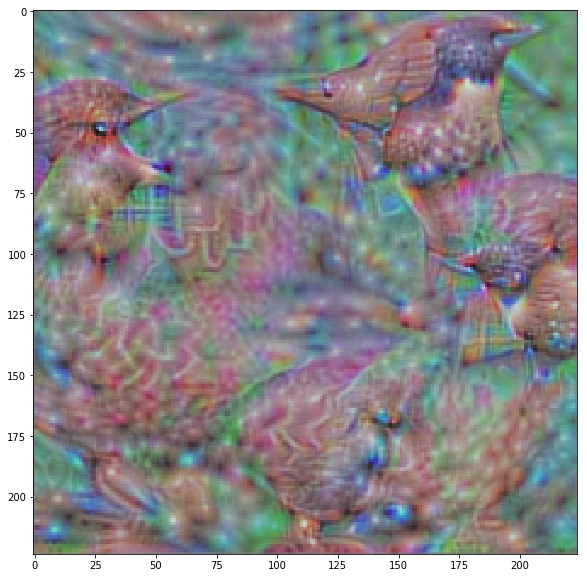

In [40]:
train_function = build_train_function_reg_laplass('predictions', indexes=(slice(None), 20), reg_coef=10)
image = compute_image_with_blur(train_function, 100, lr=0.15, blur_freq=10)
plt.imshow(image)

(None, 224, 224, 3)
(None, 112, 112, 3)
(None, 56, 56, 3)
(None, 28, 28, 3)


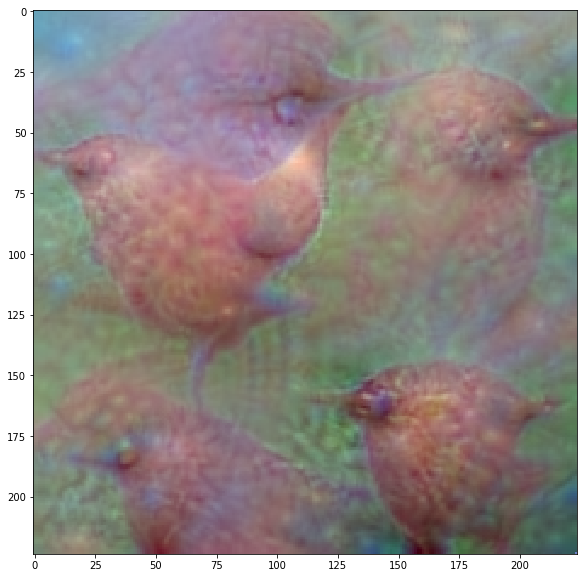

In [219]:
train_function = build_train_function_reg_laplass('predictions', indexes=(slice(None), 20), reg_coef=10)
image = compute_image_with_blur(train_function, 500, lr=0.25, blur_freq=None)
plt.imshow(image)

============================

In [41]:
def compute_image_jiter(train_function, max_iter = 50, lr = 1, jitter=20, rotation=5):
    input_img_data = np.random.normal(size=(1, 224, 224, 3))

    for i in range(max_iter):
        grads_value, objective_value = train_function([input_img_data])
        grads_value /= grads_value.std()+1e-8
        input_img_data += grads_value * lr
        
        if jitter != 0:
            jitter_rand = np.random.randint(-jitter, jitter + 1)
            input_img_data = shift(input_img_data, [0,jitter_rand,jitter_rand,0], mode='wrap', order=0)
        
        if rotation != 0:
            degree_rand = np.random.randint(-rotation, rotation + 1)
            input_img_data = rotate(input_img_data,degree_rand,mode='wrap', order=0, reshape=False)
        print(f'objective: {np.mean(objective_value):.2}', end='\r')
    
    img = input_img_data[0]
    img = deprocess_image(img)
    return img